# 충치 이미지 구분 프로젝트

### 사용 패키지

In [68]:
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver #동적 웹페이지 패키지
from selenium.webdriver.common.keys import Keys # 동적 웹페이지 스크롤 패키지
import time # 동적 웹페이지 시간 지연 설정 패키지
from selenium.webdriver.common.by import By #동적 웹페이지 By 클래스
import urllib.request as req # 웹페이지 사진 다운로드
from pandas import DataFrame, Series
import os #폴더 생성 패키지
from PIL import Image #사진 불러오기
import glob #전체 사진 불러오기
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense, Dropout #CNN 사진 학습
from tensorflow.keras.models import Model, Sequential #CNN 사진 학습
from sklearn.model_selection import train_test_split #train, test 데이터셋 분리
from tensorflow.keras.preprocessing.image import ImageDataGenerator #이미지 학습시 변형
from keras.preprocessing.image import img_to_array, load_img, array_to_img #이미지 불러오기, array로 변환
import numpy as np #array로 변환한 이미지 데이터 사용
import tensorflow as tf
import seaborn as sns
import matplotlib.pylab as plt

### 충치사진 스크래핑을 통해 수집 (구글)

In [2]:
url1='https://www.google.com/search?q='
url2='&source=lnms&tbm=isch&sa=X'
lst = ['충치','충치 사진','유아 충치','dental caries'] #충치 한글, 영문으로 검색

In [ ]:
driver = webdriver.Chrome('c:/data_bigdata/chromedriver.exe')
for j in lst:
    pic_link=[]
    driver.get(url1+j+url2) # 충치 이미지 주소로 이동
    # 스크롤 페이지 최하단까지 내리기
    for i in range(10): # 스크롤 후 결과 더보기가 뜨면 클릭
        driver.find_element(By.TAG_NAME,'body').send_keys(Keys.END)
        time.sleep(1)
        try: 
            driver.find_element(By.CLASS_NAME,'r0zKGf').click()   
            time.sleep(1)
        except:
            try:
                driver.find_element(By.CLASS_NAME,'YstHxe').click()
                time.sleep(1)
            except:
                pass
    html = driver.page_source # 현재 페이지 소스 변수 저장
    soup = BeautifulSoup(html, 'html.parser') # 페이지 소스 beautiful soup 변수 저장
    for i in soup.select_one('div.OcgH4b').select('img'):
        try: #사진 저장(2가지attrs에 저장되어 try문 사용)
            pic_link.append(i.attrs['src'])
        except:
            try:
                pic_link.append(i.attrs['data-src'])
            except:
                pass
   
    # 사진 다운로드
    for i in range(len(pic_link)):
        path = 'c:/data_bigdata/dental_caries/pic/dental_caries/'
        if not os.path.isdir(path): #폴더가 존재하지 않는다면 폴더 생성
            os.makedirs(path)
        try:
            req.urlretrieve(pic_link[i],path+f'충치_{i}.jpg')
        except:
            pass

driver.close()

#### 수집된 데이터를 수기로 구분하여 정제함
정제 후 파일 이름 공통되게 수정

In [ ]:
path = "c:/data_bigdata/dental_caries/pic/dental_caries/"
files = os.listdir(path)
for index, file in enumerate(files):
    os.rename(path+file, path +'detal_caries_' + str(index)+ '.jpg')

# 수집된 사진으로 모델 학습
## 1) CNN

In [59]:
pic_dir = 'c:/data_bigdata/dental_caries/pic_total/train/'
categories = ['caries','no_caries']

In [64]:
image_w = 64
image_h = 64

x=[]
y=[]

for idx, cate in enumerate(categories):
    label = [0 for i in range(2)]
    label[idx] = 1
    files = glob.glob(pic_dir+cate+'/*.jpg')
    for i in files:
        img = Image.open(i)
        img = img.convert('RGB').resize((image_w,image_h))
        data = np.array(img)
        x.append(data)
        y.append(label)
print('사진 개수 :',len(x))
print('정답 개수 :',len(y))
print('사진 shape :',x[0].shape)

사진 개수 : 240
정답 개수 : 240
사진 shape : (64, 64, 3)


In [65]:
type(x)

list

In [66]:
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(240, 64, 64, 3)
(240, 2)


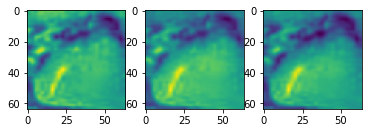

In [71]:
plt.subplot(1,3,1)
plt.imshow(x[1][:,:,0])
plt.subplot(1,3,2)
plt.imshow(x[1][:,:,1])
plt.subplot(1,3,3)
plt.imshow(x[1][:,:,2])

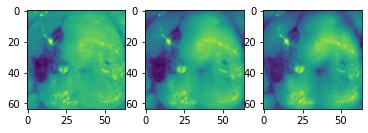

In [72]:
plt.subplot(1,3,1)
plt.imshow(x[50][:,:,0])
plt.subplot(1,3,2)
plt.imshow(x[50][:,:,1])
plt.subplot(1,3,3)
plt.imshow(x[50][:,:,2])

In [158]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [159]:
xy = (x_train,x_test,y_train,y_test)
np.save('c:/data_bigdata/dental_caries/cnn_dental_caries.npy',xy) #파일로 저장 array와 정답으로


In [160]:
print(x_train.shape)
print(x_test.shape)

(192, 64, 64, 3)
(48, 64, 64, 3)


#### 이미지 스케일 작업 후 모델 적용

In [161]:
np.max(x_train)

255

In [162]:
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [163]:
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(64,64,3),activation='relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))

model_cnn.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))

model_cnn.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(512,activation='relu'))
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(2,activation='sigmoid'))
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 8, 8, 64)       

In [164]:
model_cnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
6/6 [==============================] - 1s 155ms/step - loss: 0.6972 - accuracy: 0.6354 - val_loss: 0.5724 - val_accuracy: 0.8750
Epoch 2/20
6/6 [==============================] - 1s 142ms/step - loss: 0.6462 - accuracy: 0.6719 - val_loss: 0.4928 - val_accuracy: 0.8750
Epoch 3/20
6/6 [==============================] - 1s 144ms/step - loss: 0.6132 - accuracy: 0.6719 - val_loss: 0.4033 - val_accuracy: 0.8750
Epoch 4/20
6/6 [==============================] - 1s 144ms/step - loss: 0.5632 - accuracy: 0.6719 - val_loss: 0.4584 - val_accuracy: 0.8750
Epoch 5/20
6/6 [==============================] - 1s 142ms/step - loss: 0.5257 - accuracy: 0.7031 - val_loss: 0.3881 - val_accuracy: 0.8750
Epoch 6/20
6/6 [==============================] - 1s 146ms/step - loss: 0.4580 - accuracy: 0.8177 - val_loss: 0.2334 - val_accuracy: 0.9167
Epoch 7/20
6/6 [==============================] - 1s 143ms/step - loss: 0.3753 - accuracy: 0.8385 - val_loss: 0.3228 - val_accuracy: 0.8125
Epoch 8/20
6/6 [====

In [165]:
max_train_accuracy = history_cnn.history['accuracy'][np.argmax(history_cnn.history['accuracy'])]
max_test_accuracy = history_cnn.history['val_accuracy'][np.argmax(history_cnn.history['val_accuracy'])]
min_train_loss =history_cnn.history['loss'][np.argmin(history_cnn.history['loss'])]
min_test_loss = history_cnn.history['val_loss'][np.argmin(history_cnn.history['val_loss'])]

print('Train Accuracy 최대값:',max_train_accuracy)
print('Test Accuracy 최대값:',max_test_accuracy)
print('Train loss 최소값:',min_train_loss)
print('Test loss 최소값:',min_test_loss)

Train Accuracy 최대값: 0.8802083134651184
Test Accuracy 최대값: 0.9166666865348816
Train loss 최소값: 0.3164454698562622
Test loss 최소값: 0.2334061712026596


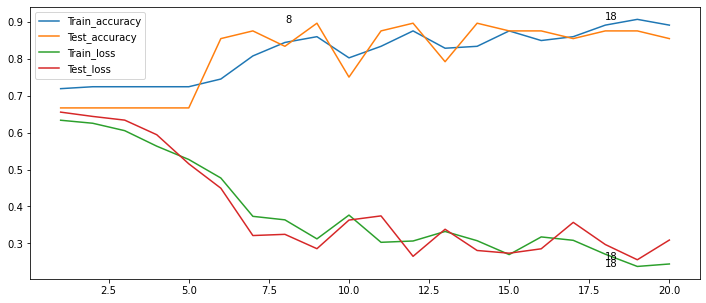

In [155]:
plt.figure(figsize=(12,5))
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['accuracy'],label='Train_accuracy');
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['val_accuracy'],label='Test_accuracy');
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['loss'],label='Train_loss');
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['val_loss'],label='Test_loss');

plt.text(np.argmax(history_cnn.history['accuracy']),max_train_accuracy,np.argmax(history_cnn.history['accuracy']))
plt.text(np.argmax(history_cnn.history['val_accuracy']),max_test_accuracy,np.argmax(history_cnn.history['val_accuracy']))
plt.text(np.argmin(history_cnn.history['loss']),min_train_loss,np.argmin(history_cnn.history['loss']))
plt.text(np.argmin(history_cnn.history['val_loss']),min_test_loss,np.argmin(history_cnn.history['val_loss']))
plt.show()

## 2) 합성곱

In [166]:
train_path = 'c:/data_bigdata/dental_caries/pic_total/train'
vali_path = 'c:/data_bigdata/dental_caries/pic_total/validation'

In [167]:
len(os.listdir('c:/data_bigdata/dental_caries/pic_total/train/caries'))

174

In [11]:
training_datagen = ImageDataGenerator(
rescale = 1./174.,
rotation_range=10,
width_shift_range=0.2,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.3,
horizontal_flip=True,
fill_mode='nearest'
)

training_generator = training_datagen.flow_from_directory(train_path,
batch_size=32,
target_size=(64,64),
class_mode='binary')

training_generator.classes

Found 244 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [12]:
training_generator.class_indices

{'caries': 0, 'no_caries': 1}

In [14]:
validation_generator = training_datagen.flow_from_directory(vali_path,
batch_size=32,
shuffle=True,
target_size=(64,64),
class_mode='binary')
validation_generator.classes

Found 17 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [15]:
validation_generator.class_indices

{'caries': 0, 'no_caries': 1}

In [22]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(64,64,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [30]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(training_generator,validation_data=validation_generator,epochs=20)


Epoch 1/20
8/8 [==============================] - 2s 180ms/step - loss: 0.3231 - accuracy: 0.8607 - val_loss: 0.4003 - val_accuracy: 0.8235
Epoch 2/20
8/8 [==============================] - 1s 171ms/step - loss: 0.3155 - accuracy: 0.8443 - val_loss: 0.2793 - val_accuracy: 0.9412
Epoch 3/20
8/8 [==============================] - 1s 150ms/step - loss: 0.3097 - accuracy: 0.8607 - val_loss: 0.2715 - val_accuracy: 0.9412
Epoch 4/20
8/8 [==============================] - 1s 150ms/step - loss: 0.2467 - accuracy: 0.8934 - val_loss: 0.2189 - val_accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - 1s 145ms/step - loss: 0.2722 - accuracy: 0.8975 - val_loss: 0.1253 - val_accuracy: 1.0000
Epoch 6/20
8/8 [==============================] - 1s 145ms/step - loss: 0.2868 - accuracy: 0.8525 - val_loss: 0.3103 - val_accuracy: 0.8824
Epoch 7/20
8/8 [==============================] - 1s 152ms/step - loss: 0.2203 - accuracy: 0.9139 - val_loss: 0.2612 - val_accuracy: 0.9412
Epoch 8/20
8/8 [====

In [31]:
history.history['accuracy'][tf.argmax(history.history['accuracy'])]

0.9180327653884888

In [32]:
history.history['val_accuracy'][tf.argmax(history.history['val_accuracy'])]

1.0

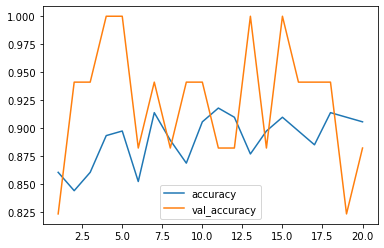

In [56]:
sns.lineplot(data=history.history,x=range(1,21,1),y=history.history['accuracy'],label='accuracy');
sns.lineplot(data=history.history,x=range(1,21,1),y=history.history['val_accuracy'],label='val_accuracy');

{'loss': [0.3231353759765625,
  0.315464586019516,
  0.30969303846359253,
  0.24673643708229065,
  0.2722042500972748,
  0.28676652908325195,
  0.22033430635929108,
  0.23870949447155,
  0.2923208177089691,
  0.2203865349292755,
  0.22808228433132172,
  0.23007363080978394,
  0.27427229285240173,
  0.2663258910179138,
  0.21951082348823547,
  0.2126324325799942,
  0.23788464069366455,
  0.2182665318250656,
  0.2212999016046524,
  0.20845948159694672],
 'accuracy': [0.8606557250022888,
  0.8442623019218445,
  0.8606557250022888,
  0.8934426307678223,
  0.8975409865379333,
  0.8524590134620667,
  0.9139344096183777,
  0.8893442749977112,
  0.868852436542511,
  0.9057376980781555,
  0.9180327653884888,
  0.9098360538482666,
  0.8770492076873779,
  0.8975409865379333,
  0.9098360538482666,
  0.8975409865379333,
  0.8852459192276001,
  0.9139344096183777,
  0.9098360538482666,
  0.9057376980781555],
 'val_loss': [0.40027928352355957,
  0.2792681157588959,
  0.271458238363266,
  0.2188892364

In [47]:
list(range(0,1,0.1))

TypeError: 'float' object cannot be interpreted as an integer